In [1]:
import os
os.environ["HF_HOME"] = "/workspace/s3/hf"

In [8]:
!pip install -r requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 30.9 MB/s eta 0:00:0000:010:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 KB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 57.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 81.5 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 60.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.7/310.7 KB 24.0 MB/s eta 0:00:00


In [2]:
from datasets import load_dataset

code_seach_net = load_dataset("code_search_net")

/workspace/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/workspace/venv/lib/python3.10/site-packages/datasets/load.py:1429: FutureWarning: The repository for code_search_net contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/code_search_net
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [3]:
python_code = code_seach_net.filter(lambda example: example["language"] == "python", num_proc=8)

In [4]:
len(python_code["train"])

412178

In [5]:
len(code_seach_net["train"])

1880853

In [6]:
import ast
import astor

def remove_docstring_and_rename_function(source_code, new_name=""):
    # Parse the source code into an AST
    tree = ast.parse(source_code)

    for node in ast.walk(tree):
        # Check if the node is a FunctionDef
        if isinstance(node, ast.FunctionDef):
            # Change the function name
            node.name = new_name

            # Check for a docstring (first expression in the function body)
            if node.body and isinstance(node.body[0], ast.Expr) and isinstance(node.body[0].value, ast.Str):
                # Remove the docstring
                node.body = node.body[1:]

    # Convert the AST back to source code
    return astor.to_source(tree)

In [8]:
from functools import partial


def remove_class_name(fc_name):
    return fc_name.split(".")[-1]

def remove_underscores(fc_name):
    return fc_name.lstrip("_")

def code_transform(code, remove_encapuslation=False):
    try:
        source_code = code["func_code_string"]
        source_code = remove_docstring_and_rename_function(source_code, new_name="x")
        function_name = remove_class_name(code["func_name"])
        if remove_encapuslation:
            function_name = remove_underscores(function_name)
        return {
            "source_code": source_code,
            "function_name": function_name,
        }
    except:
        return {
            "source_code": "",
            "function_name": "",
        }



# We remove the private/protected signatures
result = python_code.map(code_transform, fn_kwargs={"remove_encapuslation":True}, remove_columns=list(set(python_code["train"].column_names) - {"source_code", "function_name"}), num_proc=8)

Map (num_proc=8):   0%|          | 54/412178 [00:00<14:40, 467.94 examples/s]

Map (num_proc=8): 100%|██████████| 23107/23107 [00:03<00:00, 6553.51 examples/s]


In [13]:
result = result.filter(lambda example: example["source_code"].strip() != "" and example["function_name"].strip() != "", num_proc=8)

Filter (num_proc=8): 100%|██████████| 23107/23107 [00:00<00:00, 162188.66 examples/s]


In [14]:
# Print out the number of examples in each split
for split in result.keys():
    print(f"{split}: {len(result[split])}")

train: 408155
test: 21948
validation: 22817


In [15]:
print(result["train"][0]["source_code"])
print(result["train"][0]["function_name"])

def x(self):
    import scipy
    start = self._start_time
    seg = 1 - self.segmentation.astype(np.int8)
    self.stats['low level object voxels'] = np.sum(seg)
    self.stats['low level image voxels'] = np.prod(seg.shape)
    seg_border = scipy.ndimage.filters.laplace(seg, mode='constant')
    logger.debug('seg_border: %s', scipy.stats.describe(seg_border, axis=None))
    seg_border[seg_border != 0] = 1
    logger.debug('seg_border: %s', scipy.stats.describe(seg_border, axis=None))
    boundary_dilatation_distance = self.segparams[
        'boundary_dilatation_distance']
    seg = scipy.ndimage.morphology.binary_dilation(seg_border, np.ones([
        boundary_dilatation_distance * 2 + 1, boundary_dilatation_distance *
        2 + 1, boundary_dilatation_distance * 2 + 1]))
    if self.keep_temp_properties:
        self.temp_msgc_lowres_discontinuity = seg
    else:
        self.temp_msgc_lowres_discontinuity = None
    if self.debug_images:
        import sed3
        pd = sed3.sed3(

In [16]:
from pathlib import Path
import os
dst_path = Path(os.environ["HF_HOME"]) / "datasets" / "python_code"

In [17]:
# save the dataset to disk
result.save_to_disk(dst_path)

Saving the dataset (0/1 shards):   0%|          | 0/408155 [00:00<?, ? examples/s]

Saving the dataset (1/1 shards): 100%|██████████| 22817/22817 [00:00<00:00, 288713.88 examples/s]


### Exploration

In [18]:
from datasets import load_from_disk
result =  load_from_disk(dst_path)

In [19]:
from collections import Counter
function_names = [example["function_name"] for example in result["train"]]
counter = Counter(function_names)

# Print out the 10 most common function names
print("10 Most Common Function Names:")
for function_name, count in counter.most_common(10):
    print(f"{function_name}: {count}")

10 Most Common Function Names:
get: 2225
run: 1843
update: 1654
main: 1648
create: 1545
delete: 1140
parse: 1094
load: 975
save: 918
add: 908


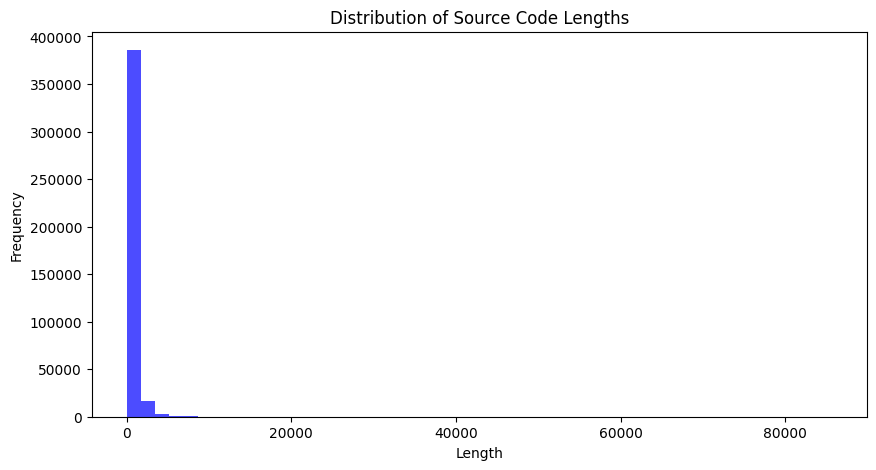

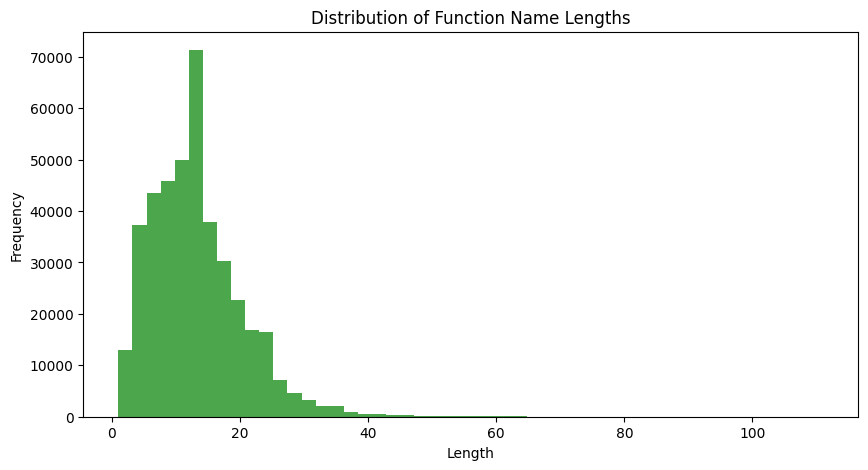

Average length of source code: 601.0983057906923
Average length of function names: 13.163545711800664


In [20]:
import matplotlib.pyplot as plt

# Calculate the length of the source code and function names
source_code_lengths = [len(example["source_code"]) for example in result["train"]]
function_name_lengths = [len(example["function_name"]) for example in result["train"]]

# Plot the distribution of source code lengths
plt.figure(figsize=(10, 5))
plt.hist(source_code_lengths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Source Code Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Plot the distribution of function name lengths
plt.figure(figsize=(10, 5))
plt.hist(function_name_lengths, bins=50, color='green', alpha=0.7)
plt.title('Distribution of Function Name Lengths')
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.show()

# Print out the average length of source code and function names
print(f"Average length of source code: {sum(source_code_lengths) / len(source_code_lengths)}")
print(f"Average length of function names: {sum(function_name_lengths) / len(function_name_lengths)}")

In [21]:
# Let's see the longest function name and source code, to make sure this is not an error on our part
longest_source_code = max(result["train"], key=lambda example: len(example["source_code"]))
longest_function_name = max(result["train"], key=lambda example: len(example["function_name"]))
print(f"Longest source code: {longest_source_code['source_code']}")
print(f"Longest function name: {longest_function_name['function_name']}")

Longest source code: def x(namespace, nicira_header, nx_action, nx_stats_request, nx_stats_reply,
    msg_subtype, action_subtype, stats_subtype):
    with _warnings.catch_warnings():
        _warnings.filterwarnings('ignore', '^padding', StructDefWarning)
        nx_flow_mod_table_id = nstruct((uint8, 'set'), (uint8[7],), name=
            'nx_flow_mod_table_id', base=nicira_header, criteria=lambda x: 
            getattr(x, msg_subtype) == NXT_FLOW_MOD_TABLE_ID, classifyby=(
            NXT_FLOW_MOD_TABLE_ID,), init=packvalue(NXT_FLOW_MOD_TABLE_ID,
            msg_subtype))
        namespace['nx_flow_mod_table_id'] = nx_flow_mod_table_id
        """
        /* NXT_SET_PACKET_IN_FORMAT request. */
        """
        nx_set_packet_in_format = nstruct((uint32, 'format'), name=
            'nx_set_packet_in_format', base=nicira_header, criteria=lambda
            x: getattr(x, msg_subtype) == NXT_SET_PACKET_IN_FORMAT,
            classifyby=(NXT_SET_PACKET_IN_FORMAT,), init=packvalue(
 

In [22]:
# Some of the source codes are very long, and we will cerntainly not be able to put them into a context length
# So let's just remove them as having first 1/5 of the source code will be useless
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("NousResearch/Llama-2-7b-chat-hf")
result_with_tokenized_source_code = result.map(lambda example: tokenizer(example["source_code"], padding=False, truncation=False), num_proc=8, batched=True)




Map (num_proc=8): 100%|██████████| 22817/22817 [00:02<00:00, 10064.93 examples/s]


In [23]:
len(result_with_tokenized_source_code["train"])

408155

In [24]:
# Let's keep some space for prompt + function name, we will be using 2048 tokens
def remove_lengthy_examples(example):
    return len(example["input_ids"]) < 1800


# Only do this for the training and validation sets
result_with_tokenized_source_code["train"] = result_with_tokenized_source_code["train"].filter(remove_lengthy_examples, num_proc=8)
result_with_tokenized_source_code["validation"] = result_with_tokenized_source_code["validation"].filter(remove_lengthy_examples, num_proc=8)
# Remove the tokenized source code
result = result_with_tokenized_source_code.remove_columns(["input_ids", "attention_mask"])


Filter (num_proc=8): 100%|██████████| 22817/22817 [00:00<00:00, 29024.97 examples/s]


In [25]:
# Calculate the number of unique function names and source codes
unique_function_names = len(set(function_names))
unique_source_codes = len(set([example["source_code"] for example in result["train"]]))

print(f"Number of unique function names: {unique_function_names}/{len(function_names)}")
print(f"Number of unique source codes: {unique_source_codes}/{len(result['train'])}")

# Calculate the most common words in the source code
from collections import Counter
import re

# Split the source code into words
words = [re.split(r'\W+', example["source_code"]) for example in result["train"]]
words = [word for sublist in words for word in sublist]  # Flatten the list

# Count the occurrences of each word
counter = Counter(words)

# Print out the 10 most common words
print("10 Most Common Words in Source Code:")
for word, count in counter.most_common(10):
    print(f"{word}: {count}")

Number of unique function names: 242618/408155
Number of unique source codes: 405813/406310
10 Most Common Words in Source Code:
self: 1250167
if: 721315
x: 514904
return: 465237
def: 432152
: 406310
in: 393461
0: 371594
None: 365286
1: 292720


In [26]:
from datasets import Dataset

def remove_duplicates(dataset: Dataset) -> Dataset:
    # Create a set of unique source codes
    unique_source_codes = dict()
    for i, example in enumerate(dataset):
        unique_source_codes[example["source_code"]] = i

    # Sort the unique samples by their index
    return dataset.select(sorted(unique_source_codes.values()))

# Do this only for the training and validation sets
result["train"] = remove_duplicates(result["train"])
result["validation"] = remove_duplicates(result["validation"])

In [54]:
# Limit the validation and test sets to 2000 examples, due to speed of evaluation
result["validation"] = result["validation"].select(range(2000))
result["test"] = result["test"].select(range(2000))
# Add messages for training
result["train"] = result["train"].select(range(10000))

def add_messages(example):
    return {
        "messages": [
                    {"role": "system", "content": f"Given the source code of a python function, suggest a fitting name for the function."},
                     {"role": "user", "content": example["source_code"]},
                     {"role": "assistant", "content": example["function_name"]}]
    }

result = result.map(add_messages, num_proc=8)

result.save_to_disk(Path(os.environ["HF_HOME"]) / "datasets" / "python_code_cleaned")

Saving the dataset (1/1 shards): 100%|██████████| 2000/2000 [00:00<00:00, 248647.12 examples/s]


In [52]:
result = load_from_disk(Path(os.environ["HF_HOME"]) / "datasets" / "python_code_cleaned_v2")